In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("dataset.csv", parse_dates=["Date"], index_col=["Date"])

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [4]:
df = df.loc[:, ['High', 'Low', 'Open', 'Close']]

In [5]:
df.describe()

,High,Low,Open,Close
count,1825.000000,1825.000000,1825.000000,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284
std,409.680853,404.310068,407.169994,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912


In [6]:
# df.mode()

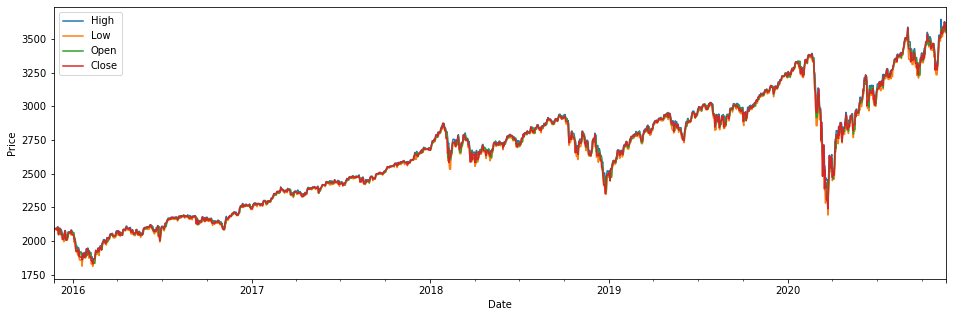

In [7]:
df.plot(figsize=(16, 5))
plt.ylabel("Price")
plt.legend()
plt.show()

In [8]:
dataset = df['Close'].values.reshape(-1, 1)

In [9]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset)
print(dataset.shape)

[[0.14323386]
 [0.14465213]
 [0.14450208]
 ...
 [0.96711598]
 [0.97494769]
 [0.96141466]]
(1825, 1)


In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size,:], dataset[train_size:,:]

In [11]:
# function for dataset creating
def create_dataset(dataset, window_size=7, horizon=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-horizon+1):
        #takes 
        a = dataset[i:(i+window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i+window_size : i+window_size+horizon, 0])
        #reshape input to be [samples, time steps, features]
        X = np.array(dataX)
        X_reshaped = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        
    return X_reshaped, np.array(dataY)

In [12]:
window_size = 7

trainX, trainY = create_dataset(train, window_size)
testX, testY = create_dataset(test, window_size)

In [13]:
train[:10]

array([[0.14323386],
       [0.14465213],
       [0.14450208],
       [0.14450208],
       [0.14519179],
       [0.14519179],
       [0.14519179],
       [0.13979629],
       [0.15215562],
       [0.13929574]])

In [14]:
trainX[:3]

array([[[0.14323386, 0.14465213, 0.14450208, 0.14450208, 0.14519179,
         0.14519179, 0.14519179]],

       [[0.14465213, 0.14450208, 0.14450208, 0.14519179, 0.14519179,
         0.14519179, 0.13979629]],

       [[0.14450208, 0.14450208, 0.14519179, 0.14519179, 0.14519179,
         0.13979629, 0.15215562]]])

In [15]:
trainY[:3]

array([[0.13979629],
       [0.15215562],
       [0.13929574]])

In [16]:
def lstm_compile(window_size, horizon=1):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True,input_shape=(1, window_size)))
    model.add(LSTM(256))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [17]:
model = lstm_compile(window_size)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1064960   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,852,673
Trainable params: 1,852,673
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# fit model
history = model.fit(trainX, trainY, epochs=10, verbose=2, shuffle=False, batch_size=25)

Epoch 1/10
59/59 - 7s - loss: 0.0022 - 7s/epoch - 111ms/step
Epoch 2/10
59/59 - 1s - loss: 0.0023 - 1s/epoch - 25ms/step
Epoch 3/10
59/59 - 1s - loss: 7.0679e-04 - 1s/epoch - 24ms/step
Epoch 4/10
59/59 - 1s - loss: 3.3000e-04 - 1s/epoch - 25ms/step
Epoch 5/10
59/59 - 2s - loss: 3.2325e-04 - 2s/epoch - 26ms/step
Epoch 6/10
59/59 - 1s - loss: 3.3643e-04 - 1s/epoch - 25ms/step
Epoch 7/10
59/59 - 2s - loss: 3.7736e-04 - 2s/epoch - 27ms/step
Epoch 8/10
59/59 - 2s - loss: 3.4296e-04 - 2s/epoch - 26ms/step
Epoch 9/10
59/59 - 1s - loss: 3.7277e-04 - 1s/epoch - 24ms/step
Epoch 10/10
59/59 - 1s - loss: 3.4248e-04 - 1s/epoch - 25ms/step


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [20]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [21]:
# function for ploting result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(16, 5), dpi=120)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Timesteps')
    plt.ylabel('Close price')
    plt.title(f'Window_size={window_size}')
    plt.show()

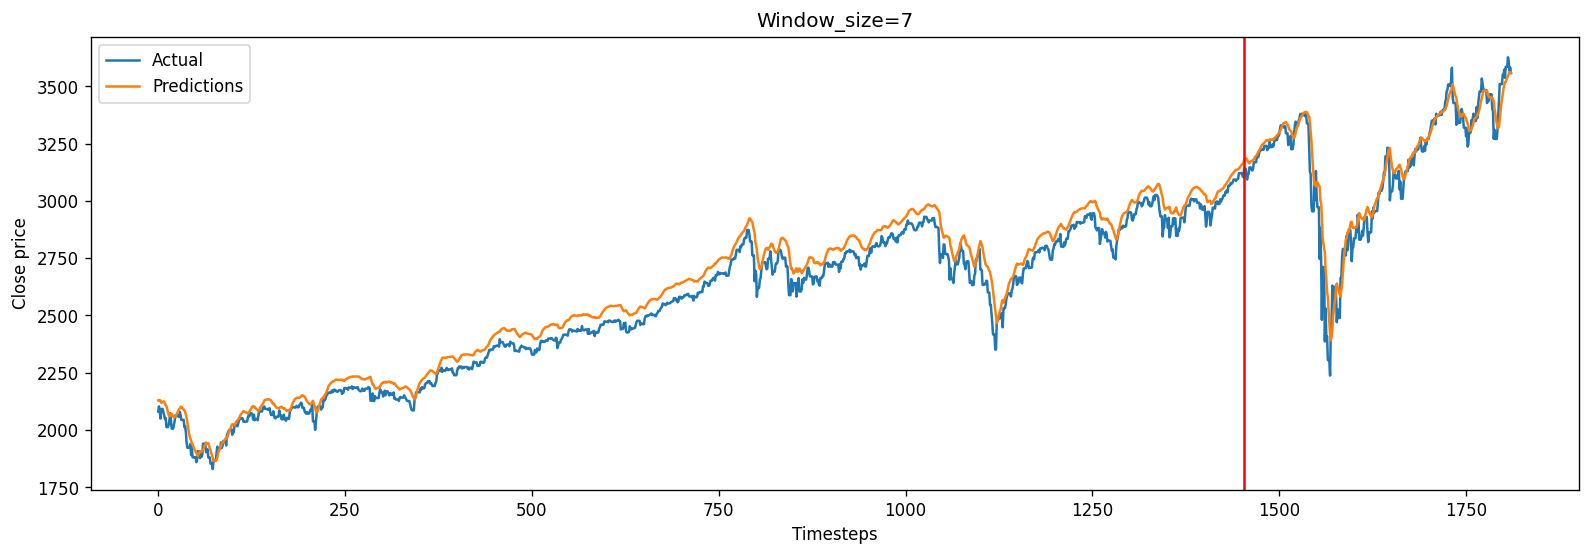

Train RMSE: 62.32, Test RMSE: 78.39


In [22]:
# plot result
plot_result(trainY, testY, trainPredict, testPredict)
# print score
trainScore = mean_squared_error(trainY[:,0], trainPredict[:,0])**0.5
testScore = mean_squared_error(testY[:,0], testPredict[:,0])**0.5
print('Train RMSE: %.2f, Test RMSE: %.2f' % (trainScore, testScore))

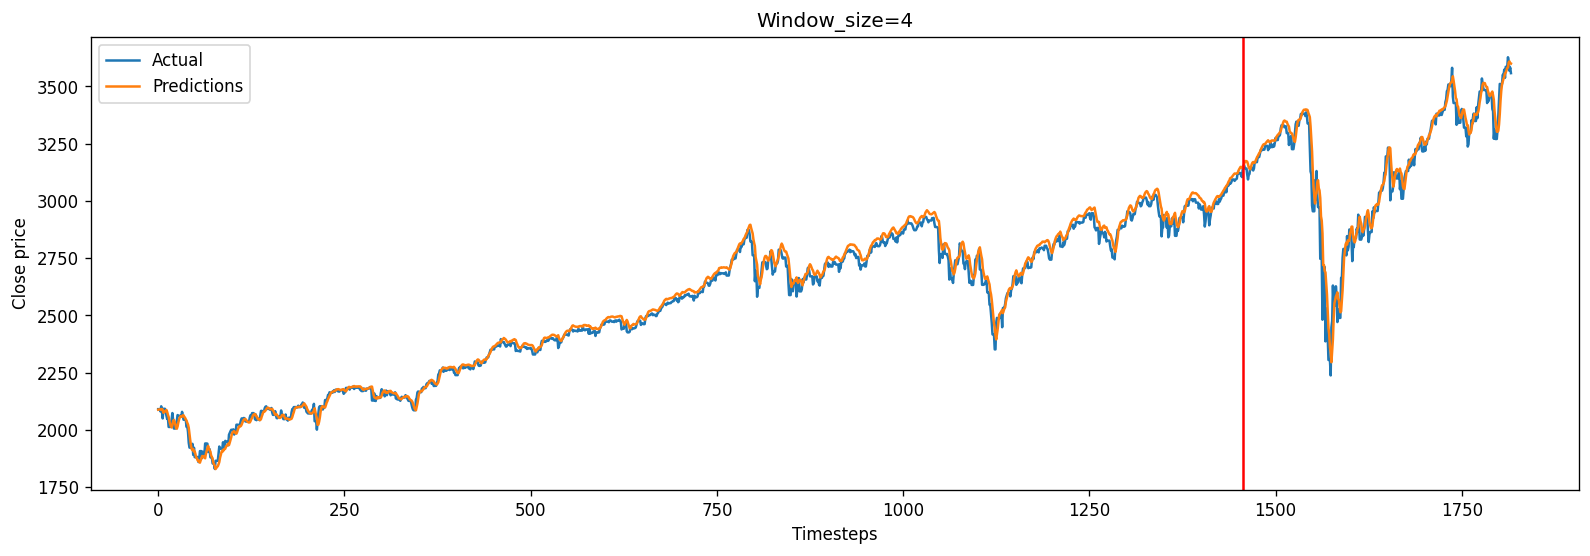

Train RMSE: 29.66, Test RMSE: 62.87
---


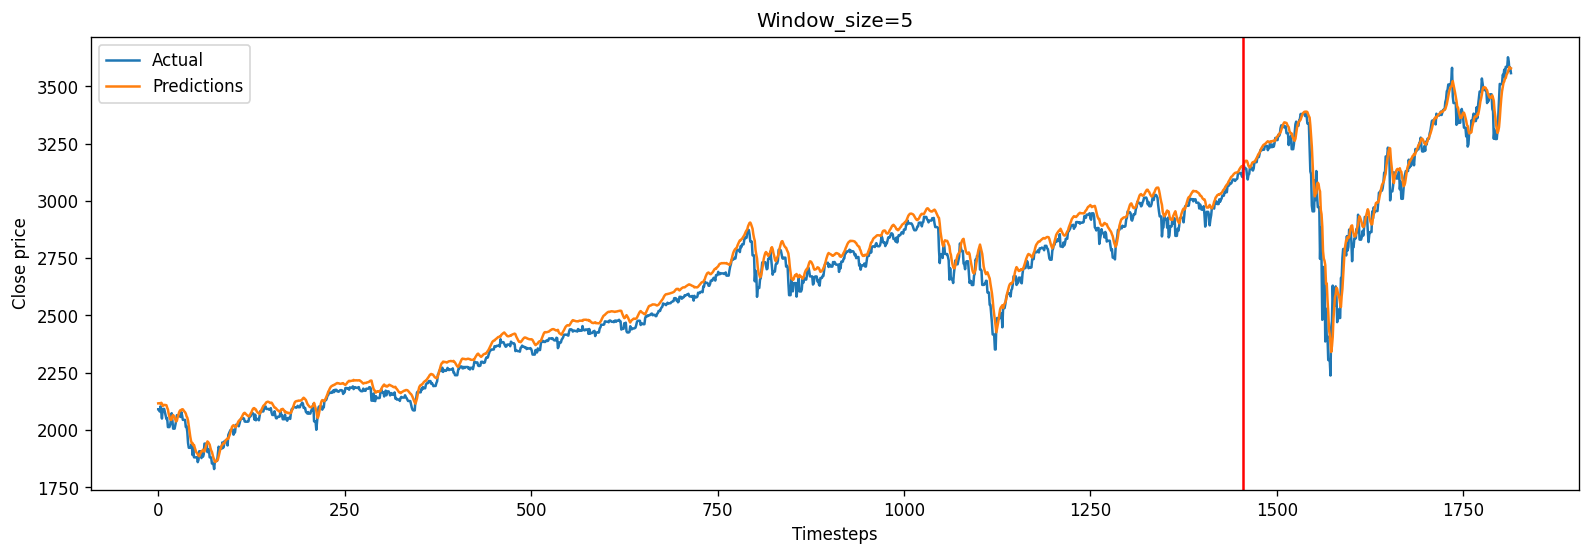

Train RMSE: 43.66, Test RMSE: 68.29
---


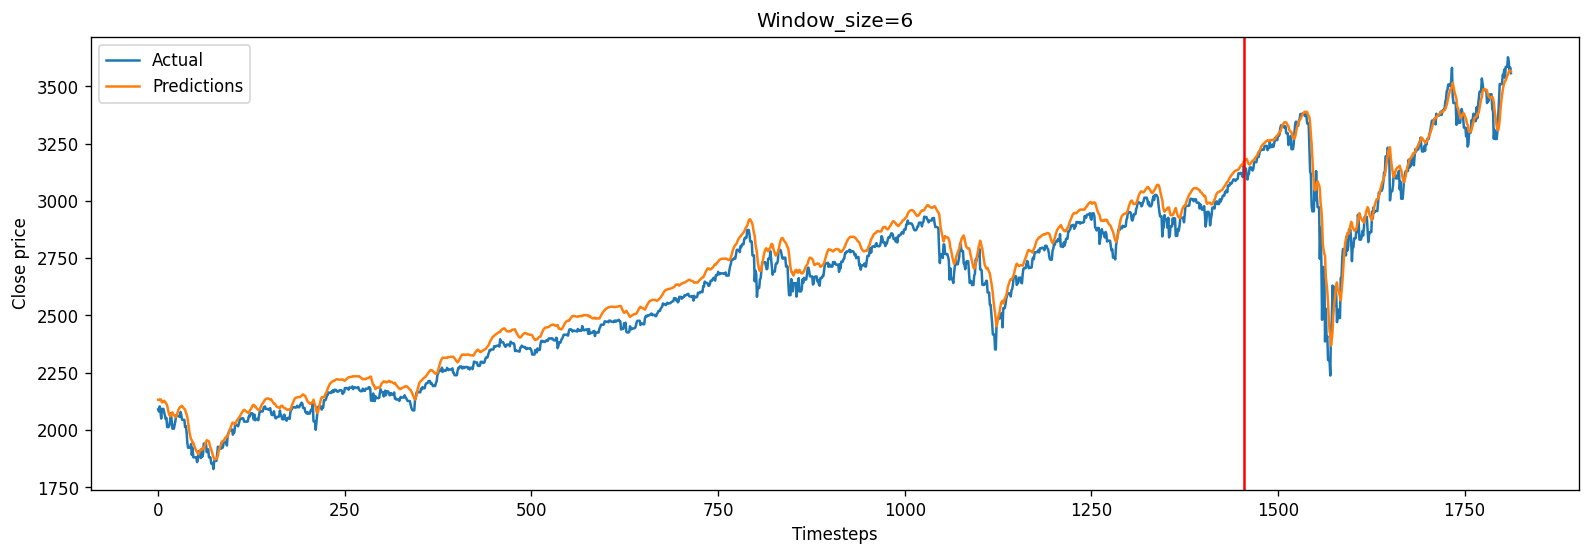

Train RMSE: 59.27, Test RMSE: 74.32
---


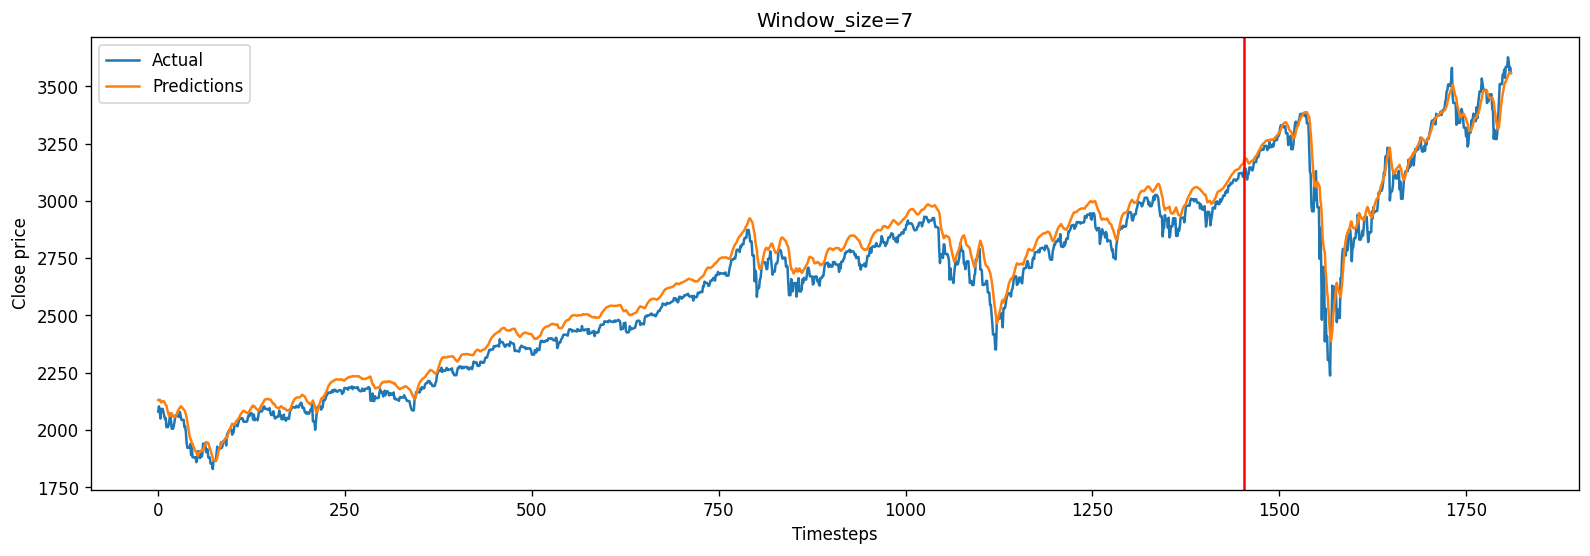

Train RMSE: 62.63, Test RMSE: 77.82
---


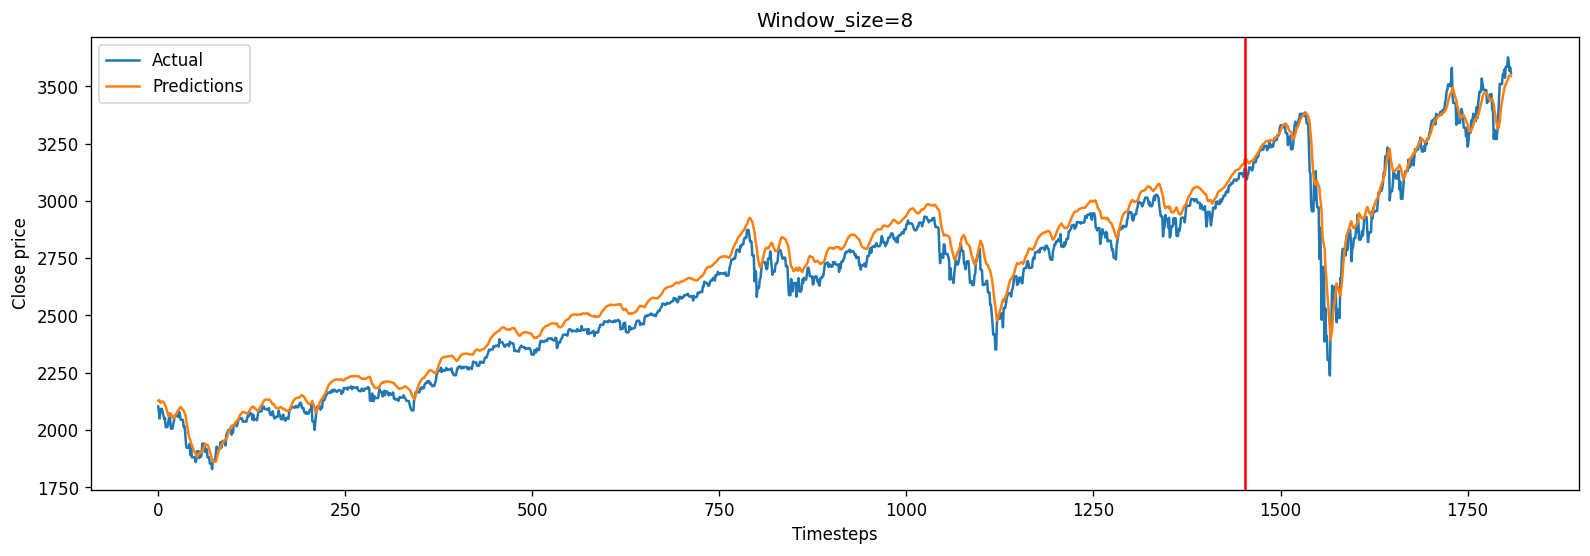

Train RMSE: 65.24, Test RMSE: 80.31
---


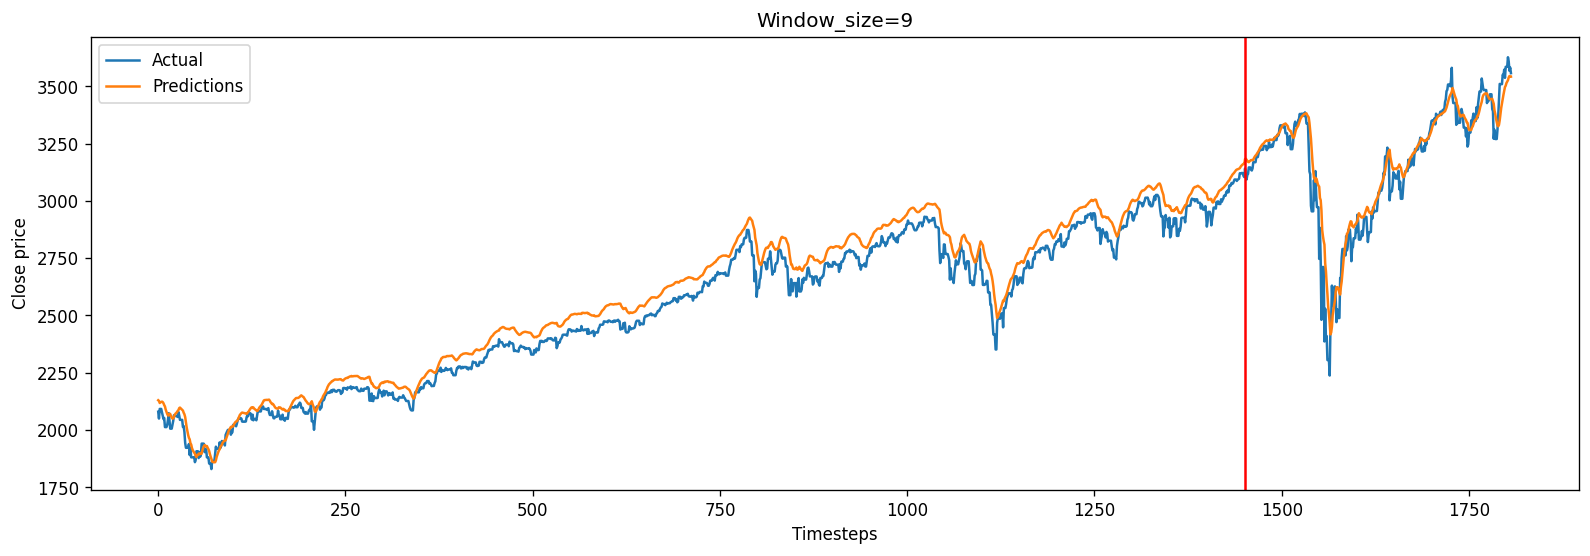

Train RMSE: 67.81, Test RMSE: 83.17
---


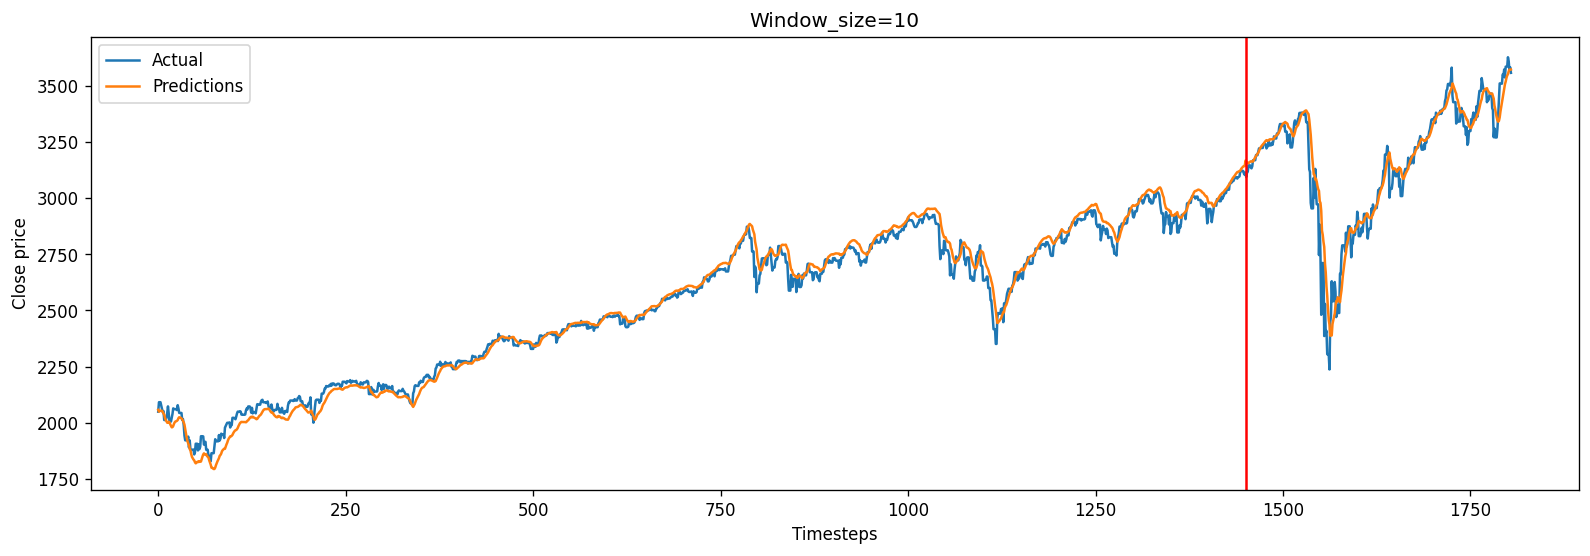

Train RMSE: 39.60, Test RMSE: 79.48
---


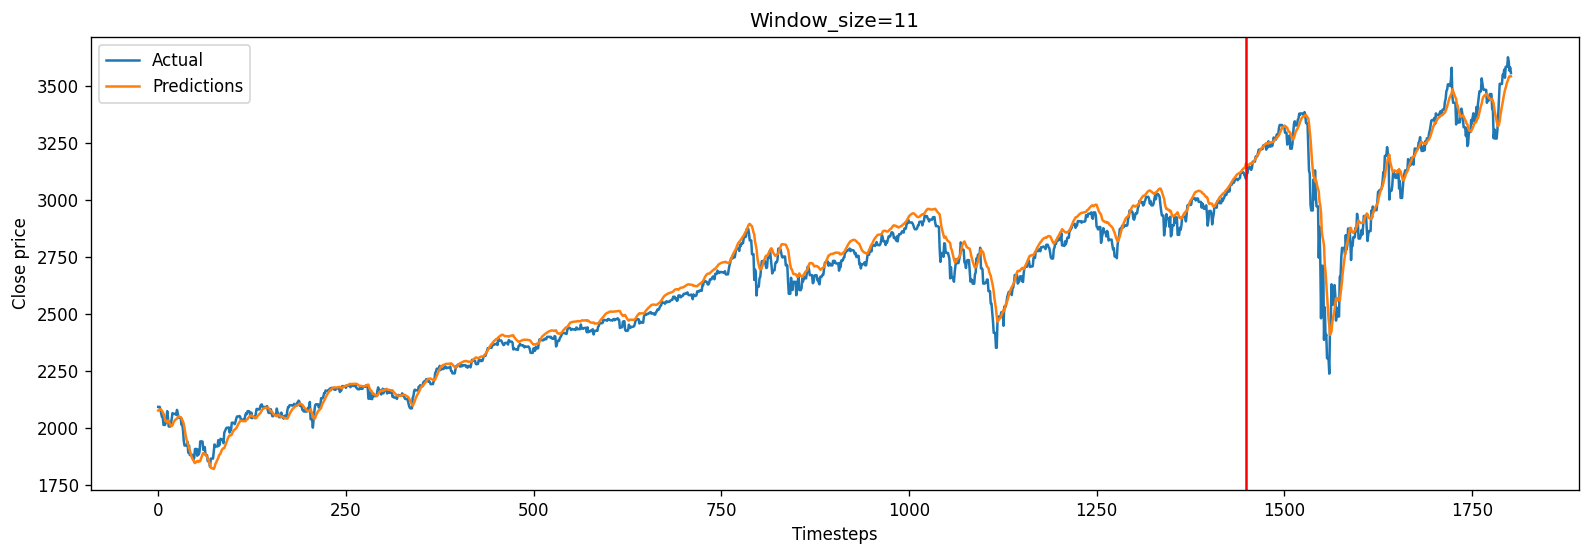

Train RMSE: 42.76, Test RMSE: 79.83
---


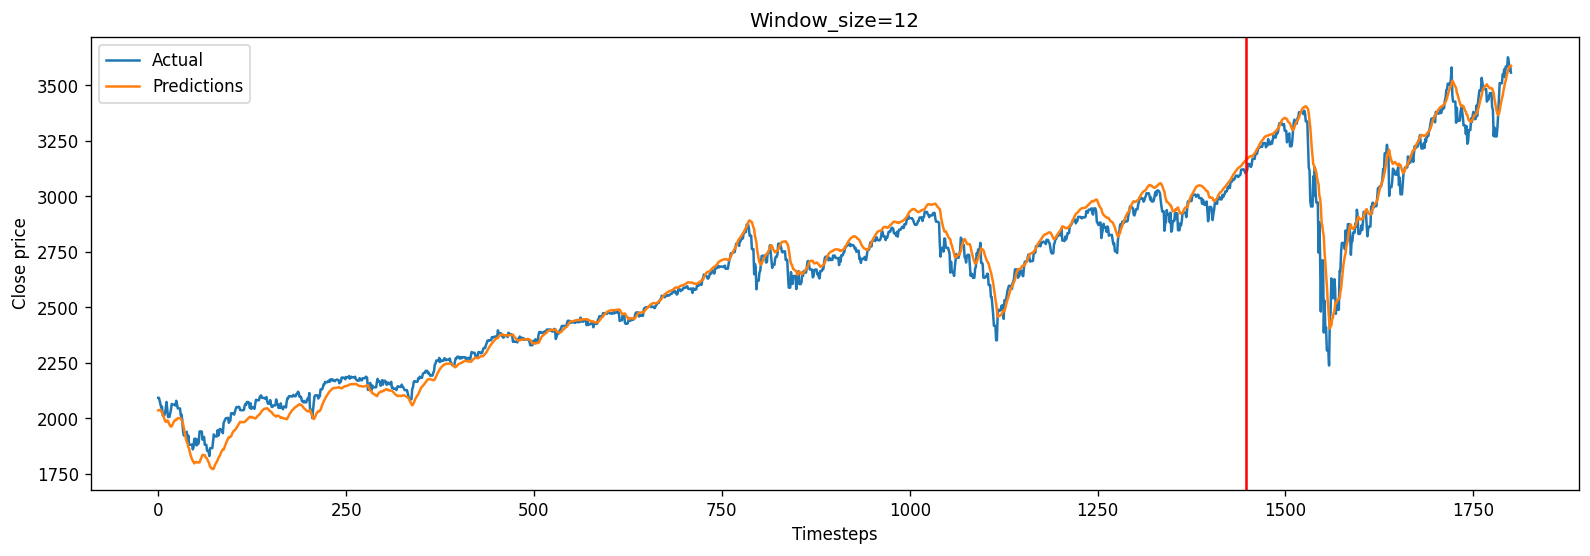

Train RMSE: 48.98, Test RMSE: 87.64
---


In [23]:
# tuning window_size

window_sizes = np.arange(4,13)
rmse_train = []; rmse_test = []

for window_size in window_sizes:
    # X loopback, Y result
    trainX, trainY = create_dataset(train, window_size)
    testX, testY = create_dataset(test, window_size)
    # create and train model
    model = lstm_compile(window_size)
    history = model.fit(trainX, trainY, epochs=10, verbose=0, shuffle=False, batch_size=25)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    # plot result
    plot_result(trainY, testY, trainPredict, testPredict)
    # print score
    trainScore = mean_squared_error(trainY[:,0], trainPredict[:,0])**0.5
    rmse_train.append(trainScore)
    testScore = mean_squared_error(testY[:,0], testPredict[:,0])**0.5
    rmse_test.append(testScore)
    print('Train RMSE: %.2f, Test RMSE: %.2f' % (trainScore, testScore))
    print('---')

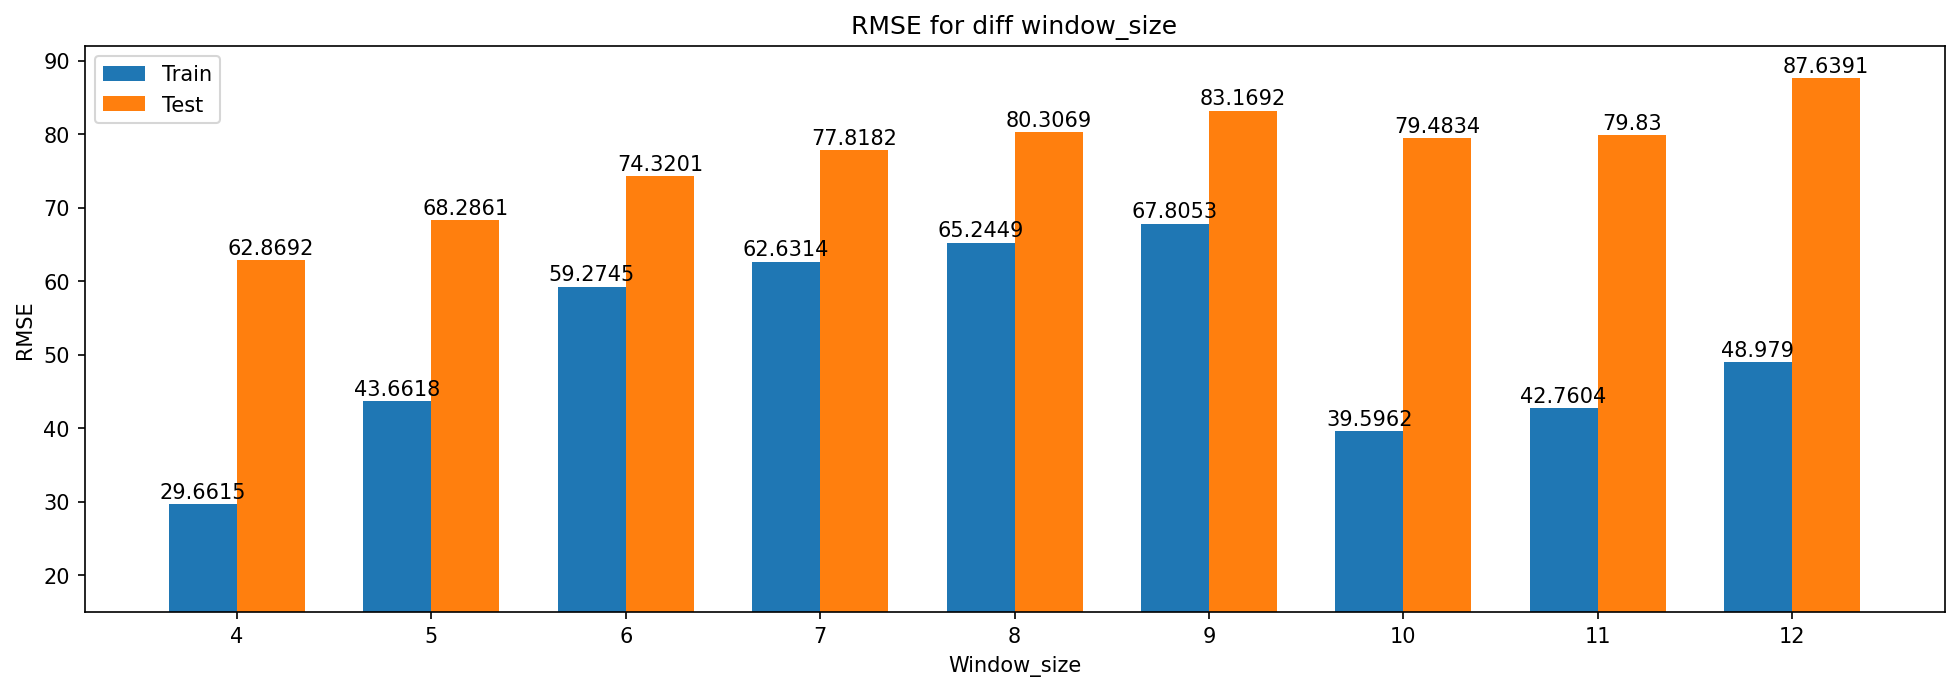

In [24]:
# plot RMSE for diff window_size
labels = window_sizes
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16,5), dpi=150)
bar1 = ax.bar(x - width/2, rmse_train, width, label='Train')
bar2 = ax.bar(x + width/2, rmse_test, width, label='Test')

ax.set_xticks(x); ax.set_xticklabels(labels)
ax.bar_label(bar1, padding=1)
ax.bar_label(bar2, padding=1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('RMSE for diff window_size')
ax.set_ylabel('RMSE')
ax.set_xlabel('Window_size')
ax.legend()

ax.set_ylim(round(min(rmse_train+rmse_test)/2))
plt.show()